In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sweetviz as sv
from scipy import stats
import seaborn as sb
# Preprocessing
from sklearn.preprocessing import LabelEncoder
# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Model selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, plot_importance, plot_tree

from sklearn.metrics import (precision_recall_curve, confusion_matrix, accuracy_score, 
                                       roc_curve, auc, f1_score, roc_auc_score, precision_score, 
                                       recall_score)
import seaborn as sns
from skopt import BayesSearchCV
from sklearn.naive_bayes import GaussianNB

In [ ]:
import sys
#installation to be done before running this code
#!{sys.executable} -m pip install sweetviz
#!{sys.executable} -m pip install scikit-optimize
#!{sys.executable} -m pip install graphviz
#in cmd,since python-graphviz is failing via notebook: conda install python-graphviz -y
!{sys.executable} -m pip3 install catboost



In [3]:
#Import dataset
dataset = pd.read_csv("bank-additional-full.csv", sep = ";")


# Recode and change target variable name
dataset['y'] = dataset['y'].apply(lambda x: 0 if x =='no' else 1)
dataset.rename(columns = {"y" : "deposit"}, inplace = True)

dataset.info()

# recorde pdays variable - it has outliers
dataset['pdays'] = dataset['pdays'].apply(lambda x: 0 if x ==999 else x)
#delete variable we had found correlated
dataset.drop(['euribor3m'], axis=1)
#create additional dataset to measure correlation before encoding
df_not_enc = pd.read_csv("bank-additional-full.csv", sep = ";")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

# Preparation operations on the data

In [4]:
# One hot encoding

# First: we create two data sets for numeric and non-numeric data
numerical = dataset.select_dtypes(exclude=['object'])
categorical = dataset.select_dtypes(include=['object'])

# Second: One-hot encode the non-numeric columns

onehot = pd.get_dummies(categorical)

# third: Third: Union the one-hot encoded columns to the numeric ones

df = pd.concat([numerical, onehot], axis=1)


X = df.loc[ : , df.columns != 'deposit']
y = df[['deposit']]

In [5]:
# Create training, evaluation and test sets
X_train, test_X, y_train, test_y = train_test_split(X, y, test_size=.3, random_state=123)
X_eval, X_test, y_eval, y_test = train_test_split(test_X, test_y, test_size=.5, random_state=123)

# we undersample X train for training the models
# use y_test for testing the models later on
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)


count_no_deposit, count_deposit = X_y_train['deposit'].value_counts()
no_deposit = X_y_train[X_y_train['deposit'] == 0]
deposit = X_y_train[X_y_train['deposit'] == 1]

no_deposit_under = no_deposit.sample(count_deposit)

train_balanced = pd.concat([no_deposit_under.reset_index(drop = True), deposit.reset_index(drop = True)], axis = 0)

round(train_balanced['deposit'].value_counts()*100/len(train_balanced['deposit']), 2)

X_train = train_balanced.loc[ : , train_balanced.columns != 'deposit']
y_train = train_balanced[['deposit']]
#NOTE: the initial X_train and y_train have 28k obs, as it is undersampled, now it has 7k, but it is still ok for the analysis

# Link to Exploratory Data Analysis



<br><font size="3">
    Please click [here](https://htmlpreview.github.io/?https://github.com/mareckiw/python_programming21/blob/main/EDA%20report.html) to visualise the EDA report.
</font></br>

<br><font size="5">
    NOTE to the Prof. Rubach:
</font></br>
<br><font size="4">
    The above code is very similar to Jose's initial project. In the below code, created by Marek Wrucha with the help of Jose Caloca we managed to create more advanced functions in python to show our knowledge. We are guided by the goal to perform the analysis of the dataset, but using more user defined and advanced functionalities in python, basically we control more of the environment the in initial Jose's analysis and we are creating some loops, functions and so on.
</font></br>

<br><font size="5">
    Additional correlation analysis using user defined functions.
</font></br>
<br><font size="4">
    It does not add any special value to the analysis, but it shows us how we can create a plot from well-known function, define our own function, use tuples and so on. Let's play.
</font></br>


In [7]:
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(11, 9))
    sb.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})

<br><font size="3">
    The above function creates simple correlation matrix with half-filled frame since we don't really need to use computing resources for the full correlation matrix, since those are mirroring values.
</font></br>

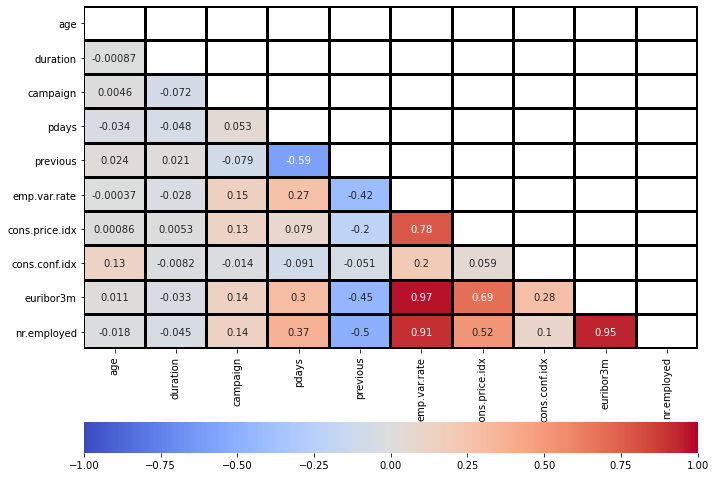

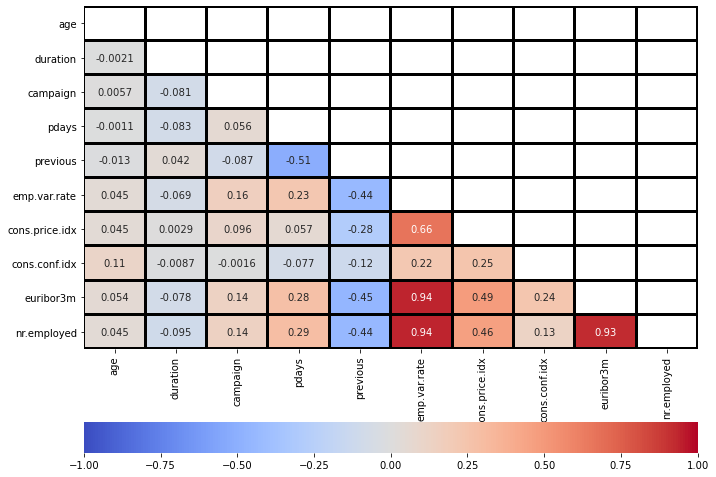

(10, 10)
(10, 10)


In [8]:
corr_pearson = df_not_enc.corr()
corr = df_not_enc.corr(method='spearman')
mask_pearson = np.triu(corr_pearson)
mask = np.triu(corr)
plot_cor_matrix(corr_pearson,mask_pearson)
plot_cor_matrix(corr,mask)
plt.show()
print(corr.shape)
print(mask.shape)

<br><font size="3">
    The calculation are performed using 2 methods of correlation, to see if there are any big differences. Since, our data is not only numeric and we have to use only spearman type of correlation in next steps.
<br />
We define a function which will create a matrix of the p_values for the correlation.
</font></br>


In [9]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            p = stats.spearmanr(df[col],df[col2]).pvalue
            #_ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
            #p_matrix[stats.spearmanr(df[col],df[col2]).correlation] = p
            #debug print
            #print(p)
    return p_matrix

<br><font size="3">
    The calculation are performed using 2 methods of correlation, to see if there are any big differences. Since, our data is not only numeric and we have to use only spearman type of correlation in next steps.
<br />
We define a function which will create a matrix of the p_values for the correlation.
</font></br>


In [10]:
# applying significance filter
p_values = corr_sig(df_not_enc)                     # get p-Value
cut_p_values = p_values[0:10,0:10]
#print("cut_p_valuesshape:", cut_p_values.shape)

<br><font size="3">
    Matrix with p-values can be now used as a mask for the plot , so kind of a filter to show onlny those correlation which are statistically significant.
</font></br>


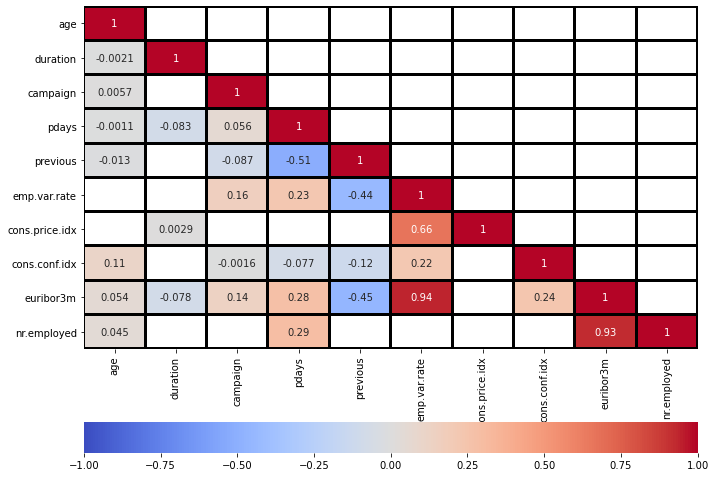

In [11]:
mask = np.invert(np.tril(cut_p_values<0.05))    # mask - only get significant corr
plot_cor_matrix(corr,mask)

<br><font size="3">
    On the basis of the table above, we will delete 1 variable (euribor3m) from the dataset since it's highly correlated withing the dependent variable. We will include the deletion in the beggining of the notebook and re-run.
</font></br>


# Preprocessing before Machine Learning

<br><font size="3">
    We need to prepare pipelines to process variables
</font></br>

In [14]:
# One hot encoder
ohe = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')
# Imputer to fulfill empty values
imp_constant = SimpleImputer(strategy='constant', fill_value='unknown')
imp_mean = SimpleImputer(strategy='mean')
# Scaling
scaler = StandardScaler()
# Columns works
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_exclude='number')

#Making one preprocessor
preprocessor = make_column_transformer(
    (make_pipeline(imp_mean, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols),
    remainder='passthrough')

<br><font size="2">
    Very simple function to print if we have any nulls in the dataset. Function returns nothing (no prints) so we are good to proceed further
</font></br>

In [15]:
#dataset.isnull().sum()
for v in dataset.isnull().sum():
    if v != 0:
        print("there are nulls")   

# Different models definition and testing

<font size="3">
    To be able to verify which algorythm of Machine Learning is performing the best we prepared 5 models:<br />
    <br>- Logistic Regression<br />
    <br>- Support Vector Classification<br />
    <br>- Random Forest<br />
    <br>- Gaussian Naive Bayes<br />
    <br>- Gradient Boosting<br />
<br>In theory, the best would be to test each model by 1, but as what Jose did in the first project attempt, the time to tune each hypermarameters etc. is very long. In order to shorten the code, as well the calculations we are testing 5 different models with default parameters. On the basis of that we will choose one model (most promising) to perform optimizations.


In [16]:
# Models definition,list
models = [LogisticRegression(max_iter=1000), 
          SVC(), 
          RandomForestClassifier(), 
          GaussianNB(), 
          XGBClassifier(use_label_encoder=False, eval_metric="logloss")]

model_names = ['logistic_regression', 'support_vector_classifier', 'random_forest', 'naive_bayess', 'xgb_model']

In [17]:
y_train=np.ravel(y_train)

In [18]:
# Loop to train and estimate the models from the models deifnition,list
results = pd.DataFrame()

for model, name in zip(models, model_names):
    print(f'Evaluating: {name}')
    pipe = make_pipeline(preprocessor, model)
    
    results.loc[name, 'train'] = cross_val_score(pipe, X_train, y_train, cv=3, scoring='roc_auc').mean()

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    results.loc[name, 'test_accuracy'] = accuracy_score(y_test, y_pred)
    results.loc[name, 'test_roc_auc'] = roc_auc_score(y_test, y_pred)
    results.loc[name, 'test_f1'] = f1_score(y_test, y_pred)
    results.loc[name, 'test_precision'] = precision_score(y_test, y_pred)
    results.loc[name, 'test_recall'] = recall_score(y_test, y_pred)
    
#print(results)

Evaluating: logistic_regression
Evaluating: support_vector_classifier
Evaluating: random_forest
Evaluating: naive_bayess
Evaluating: xgb_model


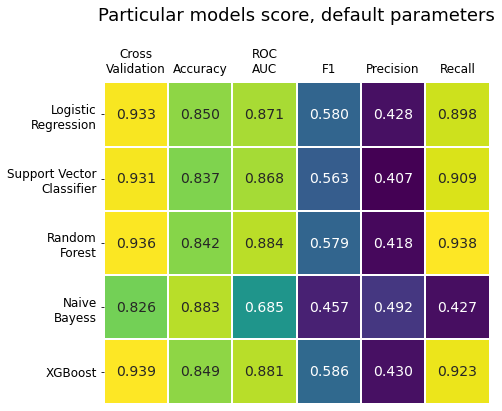

In [19]:
# Plot to show models results

plt.figure(figsize=(7,7))
sns.heatmap(results, annot=True, square=True, cmap="viridis", cbar=False,
            fmt='0.3f', annot_kws={'size':14}, linewidths=1)
plt.title('Particular models score, default parameters\n', fontdict={'fontsize':18})
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5], ['Cross\nValidation', 'Accuracy', 'ROC\nAUC', 'F1', 'Precision', 'Recall'], fontsize=12)
plt.yticks([0.5,1.5,2.5,3.5,4.5], ['Logistic\nRegression', 'Support Vector\nClassifier', 'Random\nForest', 'Naive\nBayess', 'XGBoost'],
          fontsize=12)
plt.tight_layout()
plt.show()

<br><font size="3">
    What we can see on the above chart? 
    <br />
    <br>
    5 different models were scored on the basis of different metrics. The metrics are: cross valildation on the training data, accuracy, ROC curve, F1 on the training data as well, precision, recall.<br />
    We can notice, that the best scores are: Random Forest and and XGBoost algorythm.


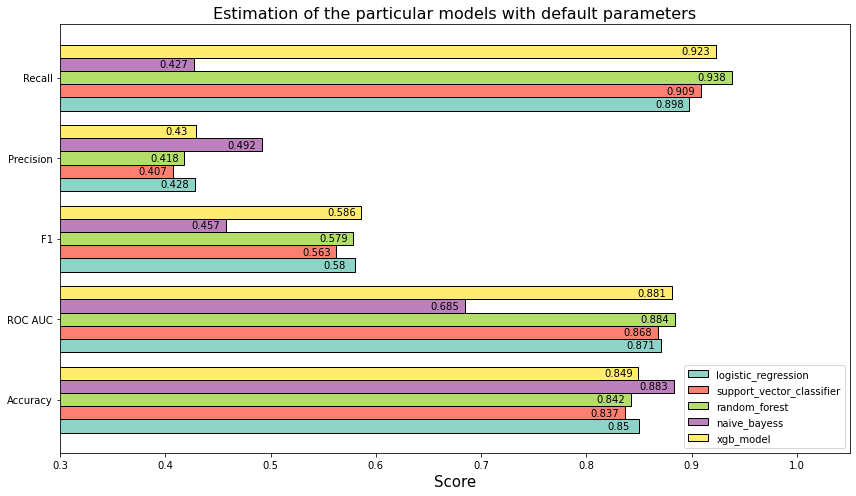

In [20]:
fig, ax = plt.subplots(figsize=(12,7))
plot = results.T.iloc[1:].plot(ax=ax, kind='barh', width=.82, cmap='Set3', edgecolor='k')

for p in plot.patches:
    plot.annotate(
        text='{:.3}'.format(p.get_width()), 
        xy=(p.get_width(), p.get_y() + p.get_height()/2),
        ha='center', 
        va='center', 
        xytext=(-20, 0), 
        textcoords='offset points', 
        color='k',
        fontsize=10)
plt.title('Estimation of the particular models with default parameters', fontdict={'fontsize':16})
plt.yticks([0,1,2,3,4], ['Accuracy', 'ROC AUC', 'F1', 'Precision', 'Recall'], rotation=0)
plt.xlim(left=.3, right=1.05)
plt.xlabel('Score', fontsize=15)
plt.tight_layout()
plt.show()

<br><font size="3">
    The chart above shows the same metrics but grouped, and so:
    <br />
    We can notice, that the best scores are: Random Forest and and XGBoost algorythm. There is also Naive Bayess performing especially well in some areas, but poor in F1 and accuracy.
    <br />
    All in all, taking into consideration those results, we decided tha XGBoost will best model to perform optimizations.
</font></br>

# Optimization of the choosen model

<br><font size="3">
    Below, we prepare dictionary with parameters to be checked in scope of tuning.
        <br />
    <br>- learning rate - learning speed
        <br />
    <br>- max_depht - maximal depth of the tree
        <br />
    <br>- min_child_weight - minimum sum of instance weight (hessian) needed in a child
        <br />
    <br>- reg_alpha - parameter L1
        <br />
    <br>- reg_lambda - parameter L2
        <br />
    <br>- gamma - parameter which controls pruning of the decision trees
        <br />    
</font>

In [21]:
# Model hiperparameters
grid_params = {
    'learning_rate': [0.05, .1, .3, .6],
    'max_depth': np.arange(2, 12, 1),
    'min_child_weight' : [1, 3, 5, 7],
    'reg_alpha': np.arange(0,10,2),
    'reg_lambda': np.arange(0,10,2),
    'gamma': [0.5, 1, 1.5, 2, 5],
    'n_estimators': [500],
    'random_state': [42]
}

# Parameters, which are allowing us to stop learning, in case of overfitting after 15 rounds (value not getting better)
fit_params = {
    'early_stopping_rounds' : 15, 
    'eval_set' : [(X_eval, y_eval)],
    'verbose': 0
}


<br><font size="3">
    Generally, the explaination why we want to stop learning in the choosen moment is below.
        <br />
</font></br>

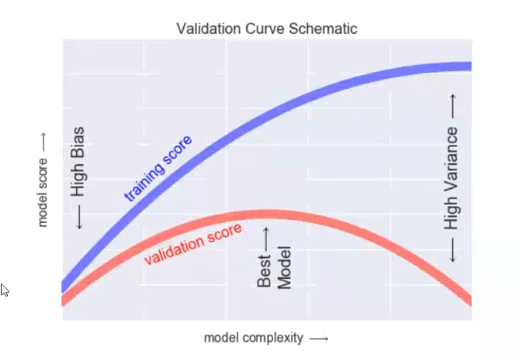

<br><font size="3">
    Below function allows us to search for the best hiperparameters on the basis of probabilistic moddel.
        <br />
</font></br>

In [22]:
opt = BayesSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    search_spaces=grid_params,
    fit_params=fit_params,
    n_iter=50,
    cv=2,
    random_state=123
)

opt = opt.fit(X_train, y_train)

<br><font size="3">
    The best founded parameters included. Those hiperparameters are used to train and validate the final (probably the best) model.
        <br />
</font></br>

In [23]:
xgb_model = XGBClassifier(use_label_encoder=False,  **opt.best_params_)
xgb_model.fit(X_train, 
        y_train, 
        early_stopping_rounds=15, 
        eval_set=[(X_eval, y_eval)], 
        eval_metric='logloss',
        verbose=0)

y_pred = xgb_model.predict(X_test)

<br><font size="4">
    Confusion matrix
        <br />
</font></br>

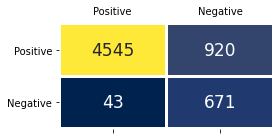

In [24]:
plt.figure(figsize=(4,2))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, cbar=False, fmt="d", linewidths=2, 
            annot_kws={'fontsize':17}, xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'], cmap="cividis")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, labeltop=True)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<br><font size="3">
    The above confusion matrix says that positively classiefied observations are 5258, but incorrectly 921. 
    <br />
    4579 are properly classified as those who are subsribing a deposit (True positives). 679 is the count of True Negatives, so those who are not and will not subscribe a deposit. 
    <br/>
    Also 886 people are incorrectly classified as a people who subsribed a deposit (False positives). 35 is the count of people who are classified incorrectly as a people who did not subsribed a deposit. (False Negative).
        <br />
</font></br>

In [25]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')

Accuracy: 0.8441495387603172
ROC AUC: 0.8857159515224206


<br><font size="3">
    One can conclude, that the model has accuracy on the level of 85% which is quite good. ROC AUC is around 89%, still not bad.

<br />The below code is to show 10 most important variables for the XGB model (the best one)
        

In [26]:
xgb_model.get_booster().feature_names = list(preprocessor.transformers_[0][2])

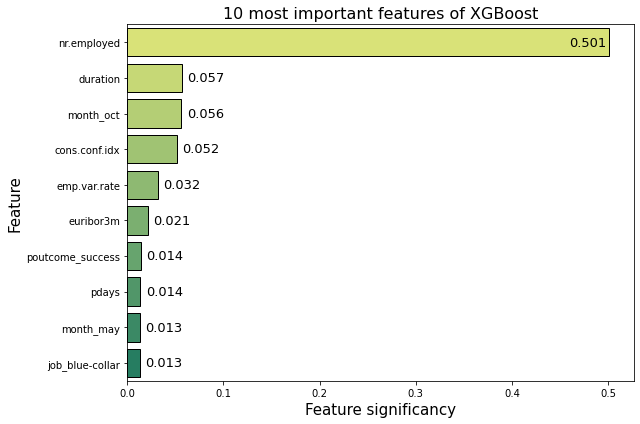

In [27]:
#xgb_model.get_booster().feature_names = preprocessor.transformers_[0][2] + list(
 #   preprocessor.transformers_[1][1]['onehotencoder'].get_feature_names())
#get features importance
f_imp = pd.DataFrame(zip(xgb_model.get_booster().feature_names, xgb_model.feature_importances_), 
                     columns=['feature', 'importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(9,6))
plot = sns.barplot(data=f_imp.head(10), y='feature', x='importance', palette='summer_r', edgecolor='k')
for p in plot.patches[0:1]:
    plot.annotate(
        text='{:.3f}'.format(p.get_width()), 
        xy=(p.get_width(), p.get_y() + p.get_height()/2),
        ha='center', 
        va='center', 
        xytext=(-22, 0), 
        textcoords='offset points', 
        color='k',
        fontsize=13)
for p in plot.patches[1:]:
    plot.annotate(
        text='{:.3f}'.format(p.get_width()), 
        xy=(p.get_width(), p.get_y() + p.get_height()/2),
        ha='center', 
        va='center', 
        xytext=(24, 0), 
        textcoords='offset points', 
        color='k',
        fontsize=13)
plt.title('10 most important features of XGBoost', fontdict={'fontsize':16})

plt.xlabel('Feature significancy', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.tight_layout()
plt.show()

<font size="3">
    Here we have a chart showing the significance of 10 most important features (variables) by the model. We can see that "nr.employed" which is number of employees is really leading influencing factor.
        

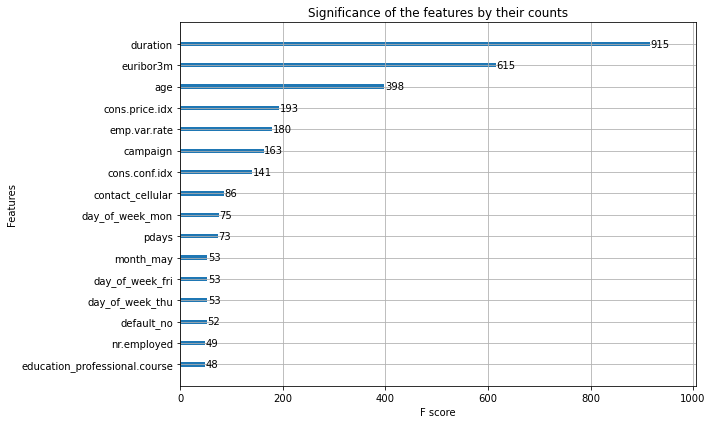

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(xgb_model, ax=ax,max_num_features=16, importance_type='weight',
                title='Significance of the features by their counts')
plt.tight_layout()
plt.show()

<font size="3">
    Graph above shows the significance of the choosen features in the model by the number of appearance in the trees. We can notice, that the most common features were "duration" which is the duration of last contact.
        

In [29]:
#debug prints
'''
print(y_test.describe())
print(y_pred)'''

'\nprint(y_test.describe())\nprint(y_pred)'

In [30]:
#proper command for commandline python-graphviz installation, any others did not work (with -v or -m functions)
#conda install -c conda-forge python-graphviz
#of course, after adding to system and user paths the location where graphviz is installed

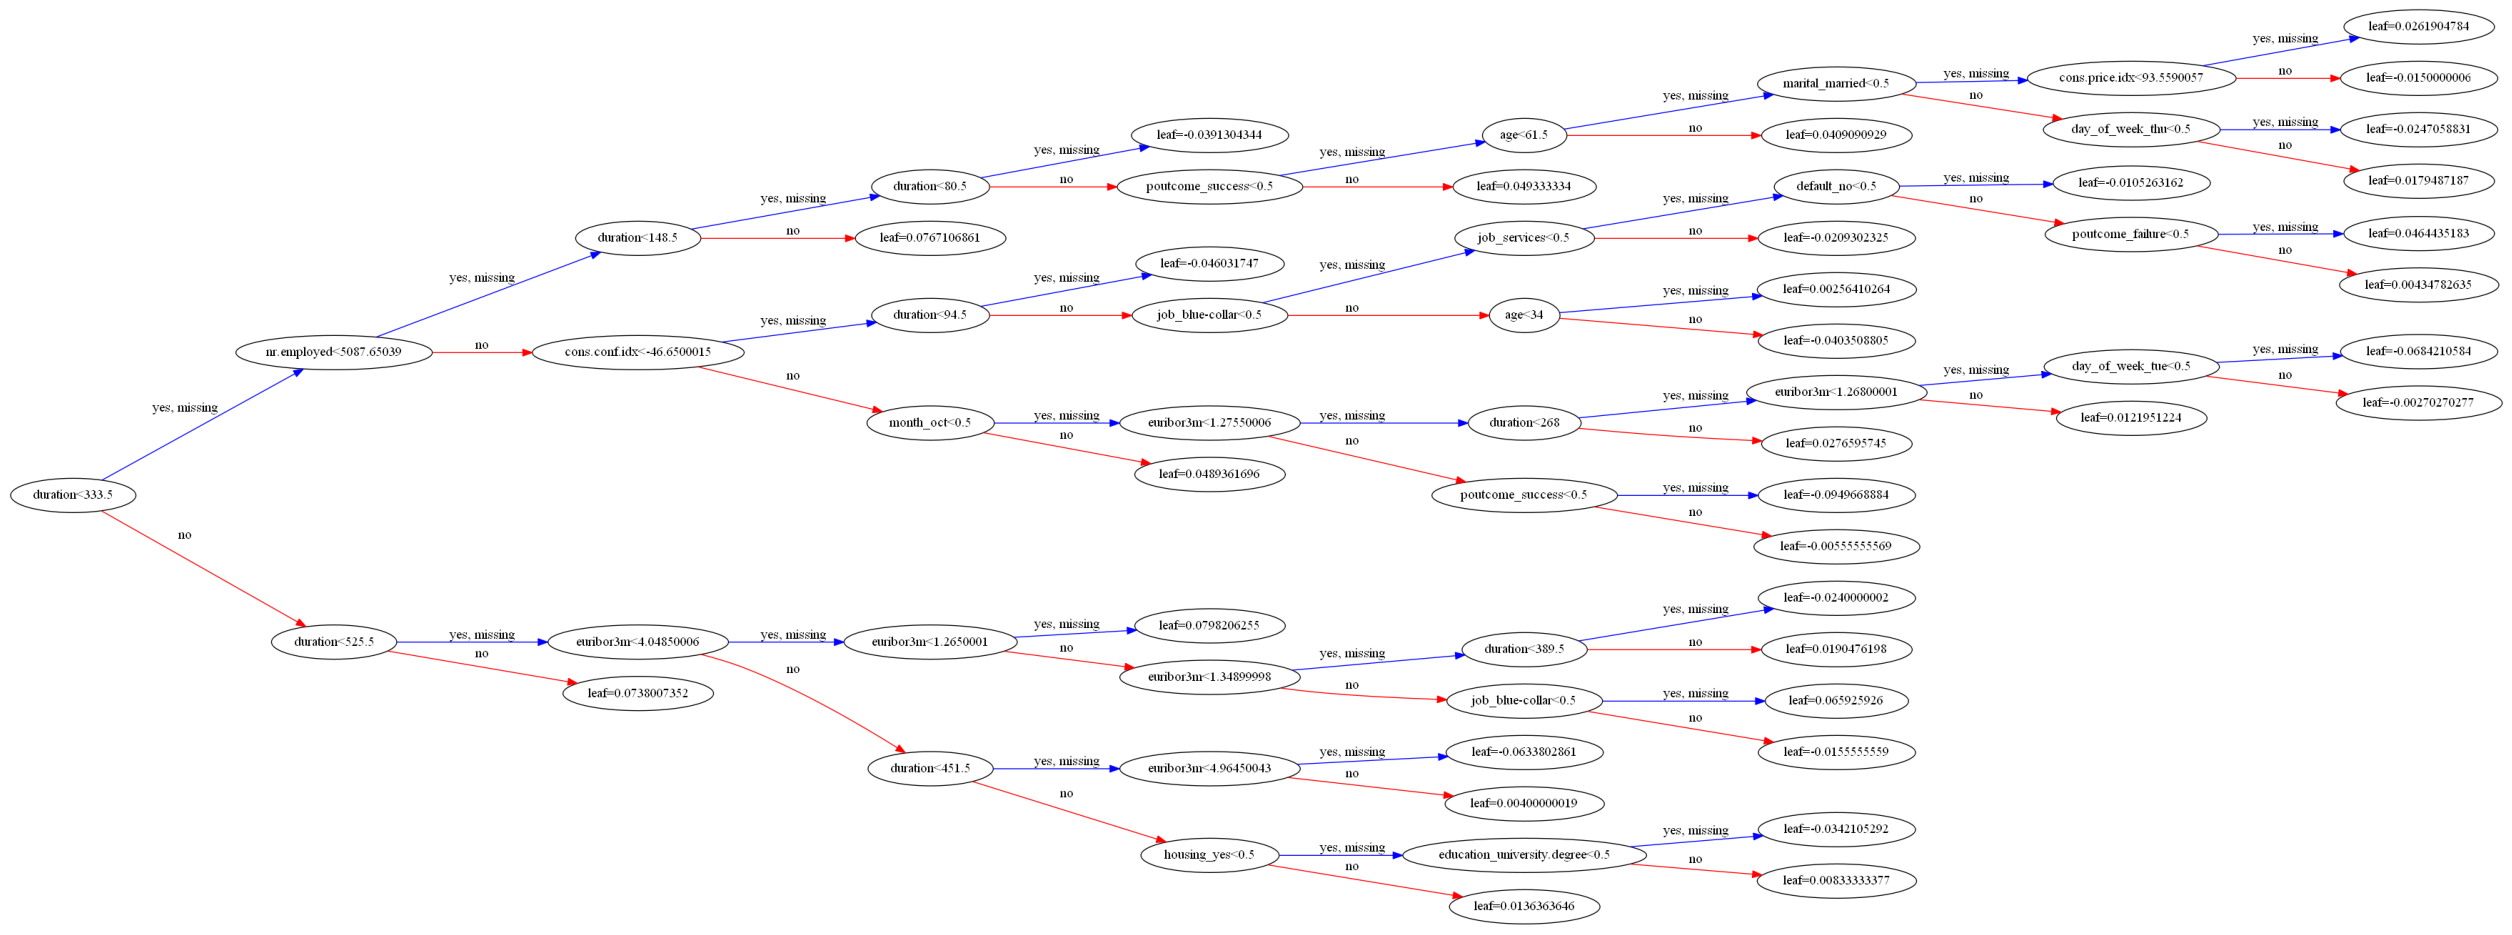

In [31]:
fig, ax = plt.subplots(figsize=(35,35))
plot_tree(ax=ax, booster=xgb_model, num_trees=0, rankdir='LR')
plt.tight_layout()
plt.show()

<br>
    Graph above shows how the model decision tree looks like.
</br>


# Summary
<br>
As shown above, we ha presented the XGBoost algorytm which scores ROC AUC around 89%. Iny our opinion the model is quite good, taking into consideration the basic parameters model. The score can be probably imporoved even more using more observations from validation part of the dataset. 
<br />
The next steps for the optimization could be probably a SVM model, or maybe a Naive Bayess, which also scored quite high.